# Import all libraries

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import lightgbm as lgbm
from lightgbm import LGBMClassifier

import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import KFold
from category_encoders import CountEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from sklearn.multioutput import MultiOutputClassifier

import os
import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

sns.set()

# Read the Dataset and clean it

In [3]:
data = pd.read_csv("train.csv")

In [4]:
data.head()

,labels,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_1190,f_1191,f_1192,f_1193,f_1194,f_1195,f_1196,f_1197,f_1198,f_1199
0,0,-2.033875,0.978446,-0.142131,-0.177117,-1.470684,1.669562,-0.196530,-0.125239,-0.452284,...,-1.111266,0.716084,0.060039,0.301279,-1.174846,-1.076498,-0.069452,-0.604012,-2.179176,0.558003
1,1,-0.348835,0.294815,-0.557577,-2.020773,-1.234715,1.633930,-1.680658,-0.358146,0.166122,...,0.735240,0.829781,1.521941,1.347946,0.754505,1.330642,-0.754453,0.582956,0.252671,1.495870
2,1,0.113248,-0.607726,-0.947791,0.830851,0.998291,0.498321,-1.493958,0.789572,-1.311018,...,0.104698,0.616189,-1.035953,2.111387,-0.984415,1.148076,-1.433554,0.243372,0.170083,1.274795
3,0,1.223321,-0.479048,-1.925789,1.680377,0.021840,-1.453307,0.605559,-0.019024,1.065448,...,0.360237,-1.957863,-0.123384,1.505329,0.660290,-1.769443,-0.547756,-0.568122,0.244645,0.982116
4,0,0.160109,0.422684,-0.308029,0.227744,0.432854,0.608348,0.193832,1.035091,-0.538868,...,0.416629,1.441766,0.212572,-0.994721,1.143999,-2.166923,-1.199248,-1.028636,0.752791,0.317169


In [5]:
data.isnull().sum()

labels    0
f_0       0
f_1       0
f_2       0
f_3       0
         ..
f_1195    0
f_1196    0
f_1197    0
f_1198    0
f_1199    0
Length: 1201, dtype: int64

In [6]:
data.shape

(5250, 1201)

In [7]:
dep = data["labels"]
indep = data.drop(columns=["labels"])

# Split the data into training and test sets

In [8]:
x_train, x_test, y_train, y_test = train_test_split(indep, dep, test_size=0.2, random_state= 42)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(4200, 1200)
(4200,)
(1050, 1200)
(1050,)


In [9]:
test_data = pd.read_csv("test.csv")
test_data.head()

,id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_1190,f_1191,f_1192,f_1193,f_1194,f_1195,f_1196,f_1197,f_1198,f_1199
0,1,-3.388242,0.868285,-0.427619,-0.678964,-1.625735,0.262761,1.243040,1.537751,-0.352028,...,-0.776403,-0.662884,-0.257091,-1.168413,0.223260,-0.482520,-0.085453,-0.382265,-0.539349,-1.682404
1,2,-0.496920,0.952381,0.989040,0.451422,0.513516,-0.099658,-1.124326,0.729430,-0.216224,...,0.379635,-1.760084,1.125450,-0.328047,-0.880305,-1.257607,0.964312,2.021104,0.655021,-0.423029
2,3,1.128369,-0.537951,2.544358,1.165254,-1.904994,0.776961,-0.495768,0.060111,-1.418468,...,1.165254,-1.373589,-0.483701,-0.964782,-0.869555,0.066040,-0.444567,-0.531935,-0.878660,1.099488
3,4,0.051253,1.746814,0.681177,1.844524,-0.327977,1.226839,-0.085519,0.379008,-1.003667,...,-0.442288,-2.794472,-0.763468,-0.789832,-0.113209,-2.703150,-2.058728,1.070627,-0.458045,-0.435825
4,5,1.423209,-0.983594,-1.694170,1.197507,1.044211,0.518777,-0.298612,-0.365174,0.738447,...,-2.624450,-3.200223,0.711422,-0.190394,0.337224,-1.656639,0.707360,-0.562290,1.471181,-0.192000


In [10]:
test_indep = test_data.drop(columns = ['id'])
test_indep

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_1190,f_1191,f_1192,f_1193,f_1194,f_1195,f_1196,f_1197,f_1198,f_1199
0,-3.388242,0.868285,-0.427619,-0.678964,-1.625735,0.262761,1.243040,1.537751,-0.352028,-0.114245,...,-0.776403,-0.662884,-0.257091,-1.168413,0.223260,-0.482520,-0.085453,-0.382265,-0.539349,-1.682404
1,-0.496920,0.952381,0.989040,0.451422,0.513516,-0.099658,-1.124326,0.729430,-0.216224,-0.000680,...,0.379635,-1.760084,1.125450,-0.328047,-0.880305,-1.257607,0.964312,2.021104,0.655021,-0.423029
2,1.128369,-0.537951,2.544358,1.165254,-1.904994,0.776961,-0.495768,0.060111,-1.418468,-0.086128,...,1.165254,-1.373589,-0.483701,-0.964782,-0.869555,0.066040,-0.444567,-0.531935,-0.878660,1.099488
3,0.051253,1.746814,0.681177,1.844524,-0.327977,1.226839,-0.085519,0.379008,-1.003667,0.570237,...,-0.442288,-2.794472,-0.763468,-0.789832,-0.113209,-2.703150,-2.058728,1.070627,-0.458045,-0.435825
4,1.423209,-0.983594,-1.694170,1.197507,1.044211,0.518777,-0.298612,-0.365174,0.738447,0.054435,...,-2.624450,-3.200223,0.711422,-0.190394,0.337224,-1.656639,0.707360,-0.562290,1.471181,-0.192000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,0.889888,-0.319077,0.849589,0.822723,0.876455,0.325704,0.876455,-0.910127,0.889888,0.204808,...,0.889888,-2.226556,-0.090717,-1.393713,-0.896694,-0.399675,-0.856395,0.876455,0.863022,-0.601169
2246,1.005737,-0.064755,1.163494,1.163494,1.163494,0.724028,0.712760,-0.785929,-1.225394,1.107152,...,1.163494,-1.270468,-0.932417,-1.169053,-0.008414,-0.605636,-0.323927,1.163494,-1.315541,0.047928
2247,1.252086,1.223561,0.153859,-0.987156,0.239435,-0.003031,-1.158309,1.237823,-1.272410,0.767154,...,0.581740,-1.386512,0.809943,-1.243885,0.153859,-0.630589,1.594391,1.252086,-1.429300,1.408976
2248,1.042624,-0.129166,1.066538,1.030667,1.162195,0.707827,-1.396612,0.014319,-1.025944,0.982839,...,1.078495,-1.193343,0.086061,-0.081338,-0.978116,-0.368307,-0.129166,1.090452,-1.444440,0.468686


In [11]:
final_df = pd.DataFrame()
final_df = test_data[["id"]]
final_df

,id
0,1
1,2
2,3
3,4
4,5
...,...
2245,2246
2246,2247
2247,2248
2248,2249


# LGBM

In [12]:
best_params = {
    'num_leaves': 365,
    'learning_rate': 0.09953504603121897,
    'feature_fraction': 0.3147999395726483,
    'bagging_fraction': 0.34847746710838445,
    'bagging_freq': 4,
    'min_child_samples': 100
}

model = lgbm.LGBMClassifier(**best_params)
model.fit(x_train, y_train)
model.score(x_test, y_test)

[LightGBM] [Warning] feature_fraction is set=0.3147999395726483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3147999395726483
[LightGBM] [Warning] bagging_fraction is set=0.34847746710838445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.34847746710838445
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


0.88

In [13]:
model.predict(test_indep)

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [14]:
lis = model.predict(test_indep)

my_series = pd.Series(lis)
final_df["labels"] = lis

final_df

,id,labels
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
2245,2246,0
2246,2247,0
2247,2248,1
2248,2249,0


In [15]:
final_df.to_csv("Final_Output_LGBM.csv", index = False)

# Neural Network

In [44]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get('val_accuracy') is not None and logs.get('val_accuracy') >= 0.98:                 
            print("\nReached 88% accuracy so cancelling training!")
            self.model.stop_training = True 

In [45]:
from tensorflow.keras.layers import LSTM

callbacks = myCallback()

model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(10024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(5024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.35),
        tf.keras.layers.Dense(504, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]
)

optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=optimizer, 
loss= "binary_crossentropy", 
metrics=['accuracy'])


In [46]:
history = model.fit(x_train, y_train, epochs = 70, callbacks=[callbacks], validation_data= (x_test, y_test))

Epoch 1/70
132/132 [==============================] - 3s 17ms/step - loss: 73.1901 - accuracy: 0.7900 - val_loss: 29.8395 - val_accuracy: 0.8352
Epoch 2/70
132/132 [==============================] - 2s 15ms/step - loss: 19.4080 - accuracy: 0.8343 - val_loss: 14.0369 - val_accuracy: 0.8248
Epoch 3/70
132/132 [==============================] - 2s 15ms/step - loss: 9.4539 - accuracy: 0.8362 - val_loss: 6.2585 - val_accuracy: 0.8524
Epoch 4/70
132/132 [==============================] - 2s 15ms/step - loss: 5.0250 - accuracy: 0.8419 - val_loss: 3.7027 - val_accuracy: 0.8248
Epoch 5/70
132/132 [==============================] - 2s 15ms/step - loss: 3.3928 - accuracy: 0.8321 - val_loss: 2.9972 - val_accuracy: 0.8505
Epoch 6/70
132/132 [==============================] - 2s 15ms/step - loss: 3.2397 - accuracy: 0.8364 - val_loss: 3.7472 - val_accuracy: 0.8381
Epoch 7/70
132/132 [==============================] - 2s 15ms/step - loss: 2.3793 - accuracy: 0.8476 - val_loss: 2.3340 - val_accuracy: 0.

# Results

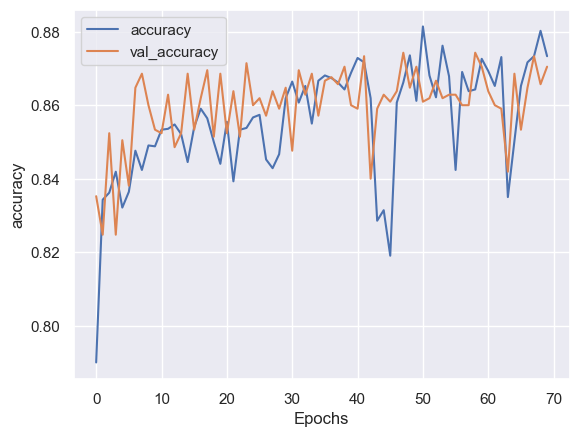

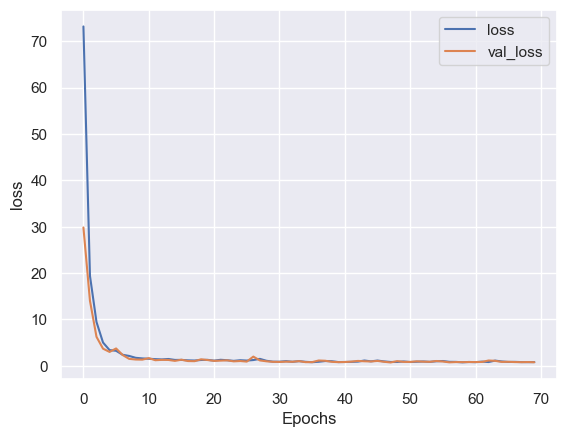

In [47]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_{}".format(metric)])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [48]:
model_predictions = model.predict(test_indep)

lis = []

for x in model_predictions:
    if x >= 0.5:
        lis.append(1)
    else:
        lis.append(0)
lis[:5]

71/71 [==============================] - 0s 5ms/step


[0, 0, 0, 0, 0]

In [50]:
my_series = pd.Series(lis)
final_df["labels"] = lis

,id,labels
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
2245,2246,0
2246,2247,0
2247,2248,1
2248,2249,0


In [51]:
final_df.to_csv("Final_Output.csv", index = False)

# DECISION TREE

In [26]:
from sklearn.metrics import accuracy_score

drugTree = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 9)
drugTree

DecisionTreeClassifier()

In [27]:
drugTree.fit(x_train, y_train)

DecisionTreeClassifier()

In [28]:
predTree = drugTree.predict(x_test)
predTree

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

In [29]:
accuracy = accuracy_score(y_test, predTree)
print("Accuracy:", accuracy)

Accuracy: 0.7685714285714286


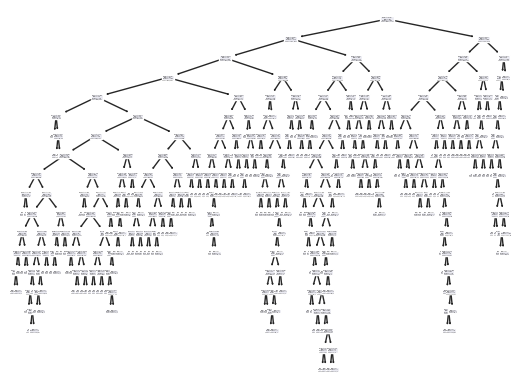

In [30]:
tree.plot_tree(drugTree)
plt.show()

In [31]:
my_series = pd.Series(predTree)
final_df["labels"] = predTree

final_df

ValueError: Length of values (1050) does not match length of index (2250)

In [ ]:
final_df.to_csv("Final_Output_Decision Tree.csv", index = False)

# XGBOOST ALGO

In [ ]:
import xgboost as xgb

In [ ]:
model = xgb.XGBClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8714285714285714


In [ ]:
model2 = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    max_depth=64,
    learning_rate=0.1,
    n_estimators=150
)

model2.fit(x_train, y_train)
y_pred = model2.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8704761904761905


In [ ]:
answers = model.predict(test_indep)

my_series = pd.Series(answers)
final_df["labels"] = my_series

final_df.head(2)

C:\Users\haris\AppData\Local\Temp\ipykernel_14764\1660317361.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["labels"] = my_series


,id,labels
0,1,0
1,2,0


In [ ]:
final_df.to_csv("Final_Output_XGBOOST.csv", index = False)

In [ ]:
answers = model2.predict(test_indep)

my_series = pd.Series(answers)
final_df["labels"] = my_series

C:\Users\haris\AppData\Local\Temp\ipykernel_14764\3105510187.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["labels"] = my_series


In [ ]:
final_df.to_csv("Final_Output_XGBOOST_Tuned.csv", index = False)

# LOGISTIC REGRESSION

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression().fit(x_train, y_train)
LR

LogisticRegression()

In [44]:
yhat = LR.predict(x_test)
yhat

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [46]:
LR.score(x_test, y_test)

0.7923809523809524

In [41]:
yhat = LR.predict(test_indep)
my_series = pd.Series(yhat)
final_df["labels"] = yhat

final_df

,id,labels
0,1,1
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
2245,2246,0
2246,2247,0
2247,2248,1
2248,2249,0


In [42]:
final_df.to_csv("Final_Output_LogiReg.csv", index = False)

In [1]:
#END